# Was Seinfeld really a show about nothing?

>JERRY: *So, we go into NBC, we tell them we've got an idea for a show about nothing.*

>GEORGE: *Exactly.*

>JERRY: *They say, "What's your show about?" I say, "Nothing."*

>GEORGE: *There you go.*

-Episode 43 - The Pitch


In [95]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.decomposition import LatentDirichletAllocation

import nltk
nltk.download('wordnet')

from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = stopwords.words("english")

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/andrewboho/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## The data

We use the the [“Seinfeld Chronicles”](https://www.kaggle.com/thec03u5/seinfeld-chronicles/home) dataset available from Kaggle. The dataset itself is split into two files: 1) episode info, and 2) scripts.

The first file contains 174 rows of episodes in seven variables:  season number, episode number, episode title, air date, writer, director, and episode ID (the season number and episode number concatenated together).

The second file contains 54,616 rows of spoken dialogue in five variables: character speaking, dialogue spoke, episode number, episode ID, and the season number. Ten rows of null dialogue were dropped leaving 54,606 used in the analysis.

We start the analysis with the epsode info data:

In [58]:
df = pd.read_csv("episode_info.csv")

# Drop duplicate index column
df.drop(["Unnamed: 0"], axis=1, inplace=True)

print("Rows: {}\nColumns: {}".format(df.shape[0], df.shape[1]))
df.head(n=5)

Rows: 174
Columns: 7


,Season,EpisodeNo,Title,AirDate,Writers,Director,SEID
0,1.0,1.0,"Good News, Bad News","July 5, 1989","Larry David, Jerry Seinfeld",Art Wolff,S01E01
1,1.0,1.0,The Stakeout,"May 31, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E01
2,1.0,2.0,The Robbery,"June 7, 1990",Matt Goldman,Tom Cherones,S01E02
3,1.0,3.0,Male Unbonding,"June 14, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E03
4,1.0,4.0,The Stock Tip,"June 21, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E04


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Data columns (total 7 columns):
Season       174 non-null float64
EpisodeNo    174 non-null float64
Title        174 non-null object
AirDate      174 non-null object
Writers      174 non-null object
Director     174 non-null object
SEID         174 non-null object
dtypes: float64(2), object(5)
memory usage: 9.6+ KB


### Preprocessing
This sets up the preprocessing and tokenization function. I first tried this with PorterStemmer, but ended up with a lot of strange stem words ("stakeout" converted to "stakeou", for example). So I decided to go with the NLTK word_netlemmatizer instead.

In [60]:
def preprocess_text(text):
    # Remove text and tokenize
    text = str(text)
    regex_pattern = r"(\w[\w']*\w|\w)"
    regex_compiled = re.compile(regex_pattern)
    tokens = regex_compiled.findall(text)
    
    # Convert to lowercase
    tokens = [word.lower() for word in tokens]
    
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    
    # Stem
    #porter = PorterStemmer()
    #tokens = [porter.stem(word) for word in tokens]
    wordnet_lemmatizer = WordNetLemmatizer()
    tokens = [wordnet_lemmatizer.lemmatize(word) for word in tokens]
    
    return tokens

In [61]:
df["title_word_list"] = df["Title"].apply(lambda x: preprocess_text(x))
df.head()

,Season,EpisodeNo,Title,AirDate,Writers,Director,SEID,title_word_list
0,1.0,1.0,"Good News, Bad News","July 5, 1989","Larry David, Jerry Seinfeld",Art Wolff,S01E01,"[good, news, bad, news]"
1,1.0,1.0,The Stakeout,"May 31, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E01,[stakeout]
2,1.0,2.0,The Robbery,"June 7, 1990",Matt Goldman,Tom Cherones,S01E02,[robbery]
3,1.0,3.0,Male Unbonding,"June 14, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E03,"[male, unbonding]"
4,1.0,4.0,The Stock Tip,"June 21, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E04,"[stock, tip]"


## Look at the show titles first
To the extent that show titles are a succinct distillation of an epside’s topic, we will look at the title names and see if they reveal any coherent  groupings that point to continuing story arcs.
### Bag-o'-words and TF-IDF

In [62]:
count_vect = CountVectorizer(tokenizer=preprocess_text)
bag = count_vect.fit_transform(df["Title"])

In [64]:
tfidf = TfidfTransformer()
tfidf_bag = tfidf.fit_transform(bag)

### LDA

In [137]:
lda = LatentDirichletAllocation(n_topics=5)
bag_topics = lda.fit_transform(tfidf_bag)

In [138]:
lda.components_.shape

(5, 17130)

In [139]:
n_top_words = 5
feature_names = count_vect.get_feature_names()
for topic_idx, topic in enumerate(lda.components_):
    print("Topic {}".format(topic_idx + 1))
    print("\n".join([feature_names[i] for i in topic.argsort()[:-n_top_words-1:-1]]))
    print()

Topic 1
yeah
hey
know
right
uh

Topic 2
well
mr
said
we're
thank

Topic 3
think
jerry
hi
hello
elaine

Topic 4
that's
oh
kramer
could
can't

Topic 5
i'm
look
sorry
need
happened



Those groupings seem pretty random to me. As far as episode titles go, there doesn't seem to be an overarching theme.

## The dialogue
Next, the same analysis is conducted on the dialogue, in searching for recurring themes or story arcs.

In [68]:
df2 = pd.read_csv("scripts.csv")
df2.head(n=10)

,Unnamed: 0,Character,Dialogue,EpisodeNo,SEID,Season
0,0,JERRY,Do you know what this is all about? Do you kno...,1.0,S01E01,1.0
1,1,JERRY,"(pointing at Georges shirt) See, to me, that b...",1.0,S01E01,1.0
2,2,GEORGE,Are you through?,1.0,S01E01,1.0
3,3,JERRY,"You do of course try on, when you buy?",1.0,S01E01,1.0
4,4,GEORGE,"Yes, it was purple, I liked it, I dont actuall...",1.0,S01E01,1.0
5,5,JERRY,"Oh, you dont recall?",1.0,S01E01,1.0
6,6,GEORGE,"(on an imaginary microphone) Uh, no, not at th...",1.0,S01E01,1.0
7,7,JERRY,"Well, senator, Id just like to know, what you ...",1.0,S01E01,1.0
8,8,CLAIRE,Mr. Seinfeld. Mr. Costanza.,1.0,S01E01,1.0
9,9,GEORGE,"Are, are you sure this is decaf? Wheres the or...",1.0,S01E01,1.0


In [70]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54616 entries, 0 to 54615
Data columns (total 7 columns):
Unnamed: 0            54616 non-null int64
Character             54616 non-null object
Dialogue              54606 non-null object
EpisodeNo             54616 non-null float64
SEID                  54616 non-null object
Season                54616 non-null float64
dialogue_word_list    54616 non-null object
dtypes: float64(2), int64(1), object(4)
memory usage: 2.9+ MB


In [71]:
df2.isnull().sum()

Unnamed: 0             0
Character              0
Dialogue              10
EpisodeNo              0
SEID                   0
Season                 0
dialogue_word_list     0
dtype: int64

In [72]:
df2.dropna(inplace=True)

In [73]:
df2.isnull().sum()

Unnamed: 0            0
Character             0
Dialogue              0
EpisodeNo             0
SEID                  0
Season                0
dialogue_word_list    0
dtype: int64

In [74]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54606 entries, 0 to 54615
Data columns (total 7 columns):
Unnamed: 0            54606 non-null int64
Character             54606 non-null object
Dialogue              54606 non-null object
EpisodeNo             54606 non-null float64
SEID                  54606 non-null object
Season                54606 non-null float64
dialogue_word_list    54606 non-null object
dtypes: float64(2), int64(1), object(4)
memory usage: 3.3+ MB


In [75]:
df2["dialogue_word_list"] = df2["Dialogue"].apply(lambda x: preprocess_text(x))
df2.head()

,Unnamed: 0,Character,Dialogue,EpisodeNo,SEID,Season,dialogue_word_list
0,0,JERRY,Do you know what this is all about? Do you kno...,1.0,S01E01,1.0,"[know, know, one, single, enjoyable, experienc..."
1,1,JERRY,"(pointing at Georges shirt) See, to me, that b...",1.0,S01E01,1.0,"[pointing, george, shirt, see, button, worst, ..."
2,2,GEORGE,Are you through?,1.0,S01E01,1.0,[]
3,3,JERRY,"You do of course try on, when you buy?",1.0,S01E01,1.0,"[course, try, buy]"
4,4,GEORGE,"Yes, it was purple, I liked it, I dont actuall...",1.0,S01E01,1.0,"[yes, purple, liked, dont, actually, recall, c..."


In [88]:
df2["Character"].value_counts().head(20)

JERRY           14786
GEORGE           9708
ELAINE           7983
KRAMER           6664
NEWMAN            640
MORTY             505
HELEN             471
FRANK             436
SUSAN             379
[Setting          293
ESTELLE           286
PETERMAN          191
PUDDY             162
WOMAN             157
MAN               143
JACK              124
MICKEY            111
BANIA             102
STEINBRENNER      101
DOCTOR             91
Name: Character, dtype: int64

Create a variable that consolidates the character names to the main four (Jerry, George, Elaine, and Kramer). This is done to make plotting easier later on.

In [110]:
def character_consolidate(name):
    if (name == "JERRY") | (name == "GEORGE") | (name == "ELAINE") | (name == "KRAMER"):
        return name
    return "OTHER"

In [114]:
df2["Character_2"] = df2["Character"].apply(lambda x: character_consolidate(x))

In [115]:
df2.head()

,Unnamed: 0,Character,Dialogue,EpisodeNo,SEID,Season,dialogue_word_list,Character_2
0,0,JERRY,Do you know what this is all about? Do you kno...,1.0,S01E01,1.0,"[know, know, one, single, enjoyable, experienc...",JERRY
1,1,JERRY,"(pointing at Georges shirt) See, to me, that b...",1.0,S01E01,1.0,"[pointing, george, shirt, see, button, worst, ...",JERRY
2,2,GEORGE,Are you through?,1.0,S01E01,1.0,[],GEORGE
3,3,JERRY,"You do of course try on, when you buy?",1.0,S01E01,1.0,"[course, try, buy]",JERRY
4,4,GEORGE,"Yes, it was purple, I liked it, I dont actuall...",1.0,S01E01,1.0,"[yes, purple, liked, dont, actually, recall, c...",GEORGE


### Bag-o'-words and TF-IDF

In [77]:
count_vect = CountVectorizer(tokenizer=preprocess_text)
bag = count_vect.fit_transform(df2["Dialogue"])

In [78]:
tfidf = TfidfTransformer()
tfidf_bag = tfidf.fit_transform(bag)

### LDA

In [93]:
lda = LatentDirichletAllocation(n_topics=5)
bag_topics = lda.fit_transform(tfidf_bag)

In [96]:
n_top_words = 10
feature_names = count_vect.get_feature_names()
for topic_idx, topic in enumerate(lda.components_):
    print("Topic {}".format(topic_idx + 1))
    print("\n".join([feature_names[i] for i in topic.argsort()[:-n_top_words-1:-1]]))
    print()

Topic 1
one
come
got
time
car
that's
i've
apartment
much
told

Topic 2
think
well
kramer
like
want
get
go
what's
i'm
see

Topic 3
yeah
oh
yes
good
know
thought
god
believe
ha
newman

Topic 4
right
hello
tell
okay
elaine
sorry
mr
way
happened
nothing

Topic 5
hey
really
that's
hi
can't
jerry
i'm
george
uh
alright



Again, I don’t see any emerging themes or story arcs. However, it’s interesting that some of the main characters show up in discrete topics. For example, topic 2 could be the “Kramer” arc, topic 4 is the “Elaine” arc, and topic 5 is the “Jerry and George” arc. Perhaps there’s a character development arc that’s hidden in the noise? I mean, character development isn’t much of a story, but it isn’t nothing either.  To see this, we take a closer look at some of the dialogue from topic five (“Jerry and George”) to see what’s going on in this bucket.

In [134]:
jerry_george = bag_topics[:,4].argsort()[::-1]

In [140]:
for iter_idx, dialogue_idx in enumerate(jerry_george[:25]):
    print("\nJerry and George example #{}".format(iter_idx + 1))
    print("{}: {}".format(df2["Character"][dialogue_idx], df2["Dialogue"][dialogue_idx]))


Jerry and George example #1
JERRY: (to the Drake) Sure! ... Okay... Don't worry, I'm taking MY car! ... okay... okay, see you later... bye...

Jerry and George example #2
JERRY: No.

Jerry and George example #3
ELAINE: Drake gave her the TV?

Jerry and George example #4
JERRY: It looks like your belt is digesting a small animal.

Jerry and George example #5
JERRY: "I dunno how you could forget . He kept reffering to himself in the third person. "Jimmy's under the boards. Jimmy's in the open. Jimmy makes the shot."

Jerry and George example #6
STAN: ..So anyway, Jerry, Elaine, we have something we want to ask you.

Jerry and George example #7
STEVE: (drunk and slurring) Oh Jerry! Jerry! Look who's here, it's Jerry

Jerry and George example #8
KRAMER: Ok, here's the deal. He wants you to acknowledge that you cut him off with an "I am sorry" wave.

Jerry and George example #9
JERRY: I'm not really a duck fan, the skin seems sort of human.

Jerry and George example #10
GEORGE: (Defensivel

No soup for me. I don’t see much of a unifying theme here either.

### PCA
For good measure, we reduce the feature set down to 2 components using PCA and plot them with colors for characters. Again we don’t find any pattern for further investigation. 

pca = PCA(n_components=2)
pca.fit(bag.toarray())

In [101]:
bag_pca = pca.transform(bag.toarray())

In [102]:
print("Original shape: {}".format(str(bag.shape)))
print("Reduced shape: {}".format(str(bag_pca.shape)))

Original shape: (54606, 17130)
Reduced shape: (54606, 2)


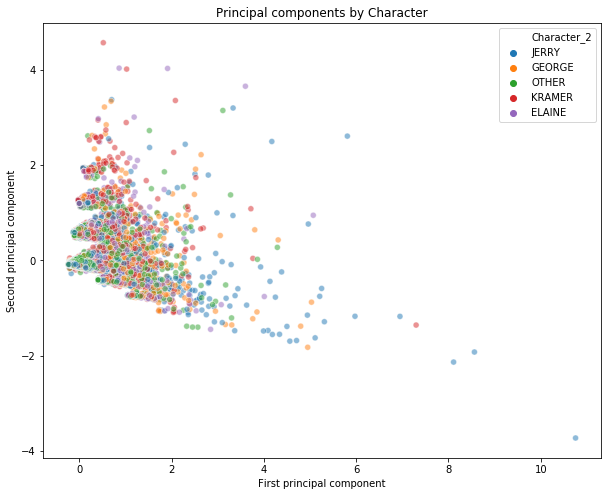

In [119]:
fig = plt.figure(figsize=(10, 8))
sns.scatterplot(bag_pca[:,0], bag_pca[:,1], hue=df2["Character_2"], alpha=0.5)
plt.title("Principal components by Character")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.show()

## Conclusion
Seinfeld truly appears to be a show about nothing. This analysis used NLP methods for feature extraction and LDA for topic discovery and found no unifying theme or a series story arc. It literally seems to be show about a bunch of random stuff that happens. Funny stuff, though.
